# 稀疏自动编码器
自动编码机更像是一个识别网络，只是简单重构了输入。而重点应是在像素级重构图像，施加的唯一约束是隐藏层单元的数量。  
  
有趣的是，像素级重构并不能保证网络将从数据集中学习抽象特征，但是可以通过添加更多的约束确保网络从数据集中学习抽象特征。  
  
稀疏自编码器（又称稀疏自动编码机）中，重构误差中添加了一个稀疏惩罚，用来限定任何时刻的隐藏层中并不是所有单元都被激活。如果 $m$ 是输入模式的总数，那么可以定义一个参数 $\hat{\rho}$，用来表示每个隐藏层单元的行为（平均激活多少次）。基本的想法是让约束值 $\hat{\rho}$ 等于稀疏参数 ${\rho}$。具体实现时在原始损失函数中增加表示稀疏性的正则项，损失函数如下：  
  
  <center>loss = MSE + 系数参数正则项</center>  
  
如果 $\hat{\rho}$ 偏离 ${\rho}$，那么正则项将惩罚网络，一个常规的实现方法是衡量$\hat{\rho}$ 和 ${\rho}$ 之间的 $KL$ 散度  
  
<center>$D_{KL}$(${\rho}$||$\hat{\rho}_{j}$) = 
${\rho}$$\log$$\frac{{\rho}}{\hat{\rho}_{j}}$ + 
(1 - ${\rho}$)$\log$$\frac{1 - {\rho}}{1 - \hat{\rho}_{j}}$</center>
  
$KL$ 散度是衡量两个分布之间差异的非对称度量，本节中，两个分布是 ${\rho}$ 和 $\hat{\rho}$。当 ${\rho}$ 和 $\hat{\rho}$ 相等时，$KL$ 散度是零，否则会随着两者差异的增大而单调增加
  
下面是 ${\rho}$ = 0.3 时的 $KL$ 的散度 $D_{KL}$ 的变化图，从图中可以看到，当 $\hat{\rho}$ = 0.3时，$D_{KL}$ = 0；而在 0.3 两侧都会单调递增
  
![$D_{KL}$散度变化](2-1Z11116400Q10.png)

## 实例：利用MNIST数据集训练稀疏自动编码器，并使用它重构测试图像

1. 导入模块

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

2. 从 TensorFlow 示例加载 MNIST 数据集

In [2]:
mnist = input_data.read_data_sets('MNIST_data')
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


3. 定义SparseAutoEncoder类，除引入 $KL$ 散度之外，它与AutoEncoder类非常相似

In [3]:
class SparseAutoEncoder:
    """稀疏自动编码器"""
    
    def __init__(self, m, n, eta=0.01):
        """
        m：输入输出层神经元数
        n：隐藏层神经元数
        """
        self._m = m
        self._n = n
        self.learning_rate = eta
        self.session = None
        
        # 构建计算图
        
        # 权重与偏置
        self._W1 = tf.Variable(tf.random_normal(shape=(self._m, self._n)))
        self._W2 = tf.Variable(tf.random_normal(shape=(self._n, self._m)))
        self._b1 = tf.Variable(np.zeros(self._n).astype(np.float32))    # 隐藏层偏置
        self._b2 = tf.Variable(np.zeros(self._m).astype(np.float32))    # 输出层偏置
        
        # 输入层占位符
        self._X = tf.placeholder('float', shape=[None, self._m])
        
        # 编码器
        self.y = self.encoder(self._X)
        
        # 解码器
        self.r = self.decoder(self.y)
        
        # 解码误差
        error = self._X - self.r
        
        # 损失函数
        self._loss = tf.reduce_mean(tf.pow(error, 2))   # MSE
        alpha = 7.5e-5
        kl_div_loss = tf.reduce_sum(self.kl_div(0.02, tf.reduce_mean(self.y, 0)))   # 由KL散度定义的稀疏参数正则项
        loss = self._loss + alpha * kl_div_loss   # MSE + 系数参数正则项
        
        # 优化算法
        self._opt = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)
        
    def logfunc(self, x1, x2):
        """对数运算"""
        return tf.multiply(x1, tf.log(tf.div(x1, x2)))
    
    def kl_div(self, rho, rho_hat):
        """计算KL散度"""
        term2_num = tf.constant(1.) - rho
        term2_den = tf.constant(1.) - rho_hat
        kl = self.logfunc(rho, rho_hat) + self.logfunc(term2_num, term2_den)
        return kl
        
    def encoder(self, x):
        """编码器"""
        h = tf.matmul(x, self._W1) + self._b1
        return tf.nn.sigmoid(h)
    
    def decoder(self, x):
        """解码器"""
        h = tf.matmul(x, self._W2) + self._b2
        return tf.nn.sigmoid(h)
    
    def set_session(self, session):
        """开启会话"""
        self.session = session
        
    def reduced_dimension(self, x):
        """降维"""
        h = self.encoder(x)
        return self.session.run(h, feed_dict={self._X: x})
    
    def reconstruct(self, x):
        """重构"""
        h = self.encoder(x)
        r = self.decoder(h)
        return self.session.run(r, feed_dict={self._X: x})
    
    def fit(self, X, epochs=1, batch_size=100):
        """训练"""
        N, D = X.shape
        num_batches = N // batch_size
        obj = []
        for i in range(epochs):
            for j in range(num_batches):
                batch = X[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run(
                    [self._opt, self._loss],
                    feed_dict={self._X: batch}
                )
                if j % 100 == 0 and i % 100:
                    print('training epoch {0} batch {2} cost {1}'.format(i, ob, j))
                obj.append(ob)
        return obj

4. 实例化 SparseAutoEncoder 类对象，调用 fit() 方法训练，然后计算重构的图像

In [5]:
Xtrain = trX.astype(np.float32)
Xtest = teX.astype(np.float32)
_, m = Xtrain.shape

sparse_auto_encoder = SparseAutoEncoder(m, 256)

# 变量初始化
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    sparse_auto_encoder.set_session(sess)
    err = sparse_auto_encoder.fit(Xtrain, epochs=10)
    out = sparse_auto_encoder.reconstruct(Xtest[:100])
    reduced_X = sparse_auto_encoder.reduced_dimension(Xtrain)
    

training epoch 1 batch 0 cost 0.022769542410969734
training epoch 1 batch 100 cost 0.019623976200819016
training epoch 1 batch 200 cost 0.018336903303861618
training epoch 1 batch 300 cost 0.017890354618430138
training epoch 1 batch 400 cost 0.016512297093868256
training epoch 1 batch 500 cost 0.01673797331750393
training epoch 2 batch 0 cost 0.015215824358165264
training epoch 2 batch 100 cost 0.013640092685818672
training epoch 2 batch 200 cost 0.013303242623806
training epoch 2 batch 300 cost 0.013452722690999508
training epoch 2 batch 400 cost 0.01259921956807375
training epoch 2 batch 500 cost 0.012764976359903812
training epoch 3 batch 0 cost 0.011628209613263607
training epoch 3 batch 100 cost 0.010353242047131062
training epoch 3 batch 200 cost 0.010234473273158073
training epoch 3 batch 300 cost 0.01082268264144659
training epoch 3 batch 400 cost 0.010119963437318802
training epoch 3 batch 500 cost 0.01041246484965086
training epoch 4 batch 0 cost 0.009589564986526966
training

5. 重构损失均方误差随网络学习的变化图

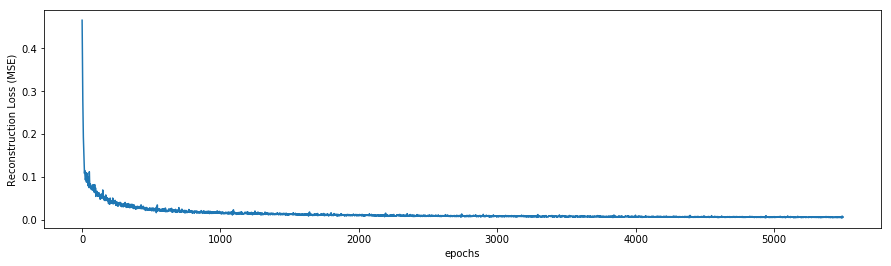

In [6]:
plt.figure(figsize=(15, 4))
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('Reconstruction Loss (MSE)')
plt.show()

6. 查看重构图像

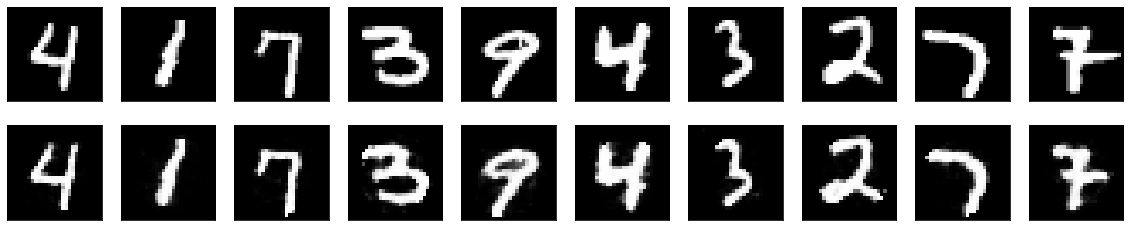

In [7]:
row, col = 2, 10
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col, sharex=True, sharey=True, figsize=(20, 4))
for fig, row in zip([Xtest, out], axarr):
    for i, ax in zip(idx, row):
        ax.imshow(fig[i].reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [8]:
reduced_X

array([[1.5912595e-01, 0.0000000e+00, 6.7457974e-02, ..., 3.1582117e-03,
        5.9604645e-08, 3.1768084e-03],
       [4.7287157e-01, 5.6150556e-04, 3.7071109e-04, ..., 1.4603138e-06,
        7.6293945e-06, 1.4901161e-07],
       [3.2122952e-01, 5.9306622e-06, 2.4676323e-05, ..., 2.4324656e-04,
        2.8181076e-04, 1.7881393e-06],
       ...,
       [1.0608700e-01, 2.1725893e-04, 3.1282395e-02, ..., 6.7442656e-05,
        5.1607221e-02, 9.3176961e-04],
       [3.2670200e-03, 2.4616718e-05, 4.5520961e-03, ..., 4.5509309e-02,
        7.1075559e-04, 9.9842846e-01],
       [2.8682441e-01, 3.3140182e-05, 7.6416594e-01, ..., 9.9897385e-05,
        1.1328921e-01, 1.4273524e-03]], dtype=float32)

In [9]:
reduced_X.shape

(55000, 256)